In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from sqlalchemy import func

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base = automap_base()

In [32]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [33]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [35]:
#inspect columns in measurement
inspector = inspect(engine)

In [36]:
# get table names
inspector.get_table_names()

['measurement', 'station']

In [37]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:
# Using the inspector to print the column names within the 'station' table and its types
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [40]:
# Checking measurement data
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [41]:
# Checking station data
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [42]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [43]:
# Find the most recent date in the data set.
engine.execute('SELECT MIN(date) FROM measurement').fetchall()

[('2010-01-01',)]

In [44]:
last_date = engine.execute('SELECT MAX(date) FROM measurement').fetchall()
last_date

[('2017-08-23',)]

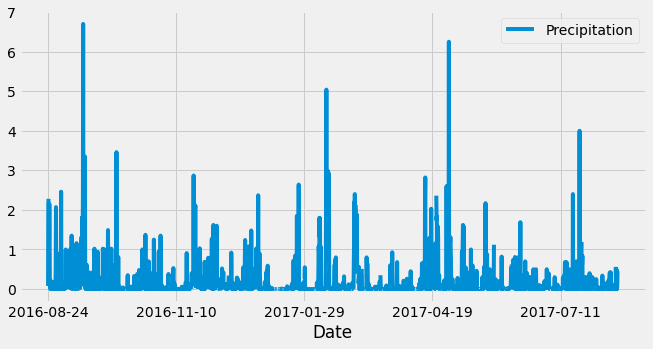

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
# last_date

# Calculate the date one year from the last date in data set.
last_year = datetime.strptime(last_date, '%Y-%m-%d') - timedelta(days=365)
# last_year

# Perform a query to retrieve the data and precipitation scores
year_prec = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_year).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(year_prec, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precip_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(figsize=(10,5))
plt.savefig("Precipitation_chart.png")

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number stations in the dataset
num_of_stations = session.query(station).count()
num_of_stations

9

In [48]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_station_df = pd.DataFrame(active_stations, columns=['Station', 'Count_of_Stations'])
active_station_df.sort_values(by=['Count_of_Stations'])

,Station,Count_of_Stations
8,USC00518838,511
7,USC00517948,1372
6,USC00511918,1979
5,USC00514830,2202
4,USC00516128,2612
3,USC00519523,2669
2,USC00513117,2709
1,USC00519397,2724
0,USC00519281,2772


In [49]:
# Most active Station
most_active_station = active_station_df.iloc[active_station_df['Count_of_Stations'].idxmax()] 
most_active_station

Station              USC00519281
Count_of_Stations           2772
Name: 0, dtype: object

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Low
lowest = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f"Lowest Temp: {lowest}")
# high
highest = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f"Highest Temp: {highest}")
# avg Temp
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f"Average Temp: {avg_temp}")

Lowest Temp: [(54.0,)]
Highest Temp: [(85.0,)]
Average Temp: [(71.66378066378067,)]


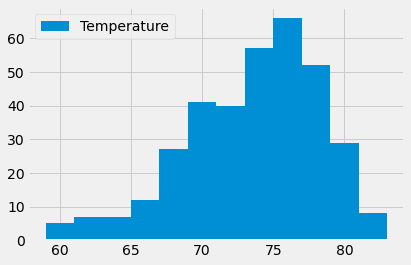

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# query to get the temperatures being observed. 
temp_observation = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= last_year).\
    group_by(measurement.date).all()


# temp_observation into a dataframe
temp_observation = pd.DataFrame(temp_observation, columns=['Date', 'Temperature'])
temp_observation = temp_observation.set_index('Date', drop=True) # set index
temp_observation

# Plot histogram
plt.hist(temp_observation['Temperature'],12, label="Temperature");
plt.legend()
plt.savefig("Temperature_chart.png")

# Close session

In [52]:
# Close Session
session.close()